# UTILS

In [19]:
import pandas as pd
# Makes sure we see all columns
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

class DataLoader():
    def __init__(self):
        self.data = None

    def load_dataset(self, path="healthcare-dataset-stroke-data.csv"):
        self.data = pd.read_csv(path)

    def preprocess_data(self):
        # One-hot encode all categorical columns
        categorical_cols = ["gender",
                            "ever_married",
                            "work_type",
                            "Residence_type",
                            "smoking_status"]
        encoded = pd.get_dummies(self.data[categorical_cols],
                                prefix=categorical_cols, dtype = int)

        # Update data with new columns
        self.data = pd.concat([encoded, self.data], axis=1)
        self.data.drop(categorical_cols, axis=1, inplace=True)

        # Impute missing values of BMI
        self.data.bmi = self.data.bmi.fillna(0)

        # Drop id as it is not relevant
        self.data.drop(["id"], axis=1, inplace=True)

        self.data = self.data.apply(pd.to_numeric, errors='coerce')

        # Standardization
        # Usually we would standardize here and convert it back later
        # But for simplification we will not standardize / normalize the features

    def get_data_split(self):
        X = self.data.iloc[:,:-1]
        y = self.data.iloc[:,-1]
        return train_test_split(X, y, test_size=0.20, random_state=2021)

    def oversample(self, X_train, y_train):
        oversample = RandomOverSampler(sampling_strategy='minority')
        # Convert to numpy and oversample
        x_np = X_train.to_numpy()
        y_np = y_train.to_numpy()
        x_np, y_np = oversample.fit_resample(x_np, y_np)
        # Convert back to pandas
        x_over = pd.DataFrame(x_np, columns=X_train.columns)
        y_over = pd.Series(y_np, name=y_train.name)
        return x_over, y_over


In [20]:
# Imports
import matplotlib.pyplot as plt


In [21]:


# Load data
data_loader = DataLoader()
data_loader.load_dataset()
data = data_loader.data

# Show head
print(data.shape)
data.head()


(5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [22]:

# Show general statistics
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


col:  id


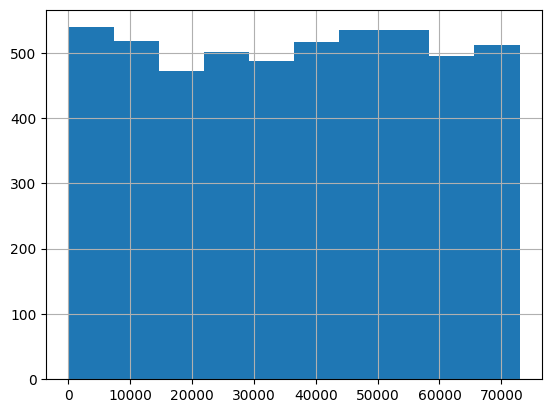

col:  gender


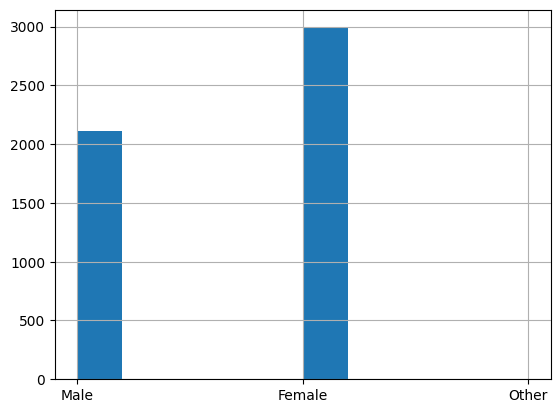

col:  age


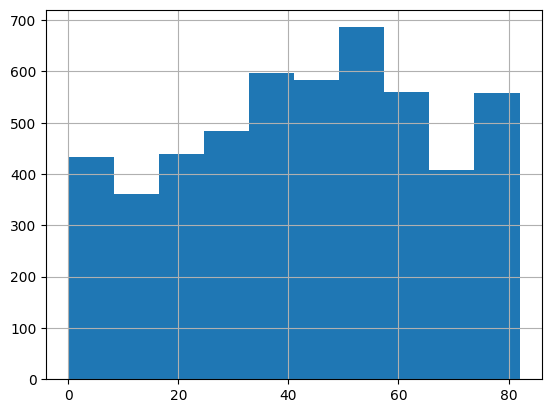

col:  hypertension


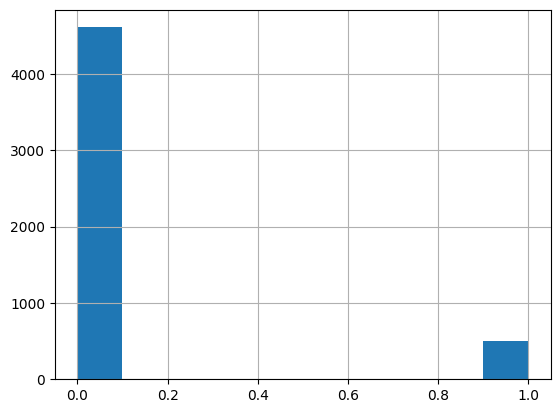

col:  heart_disease


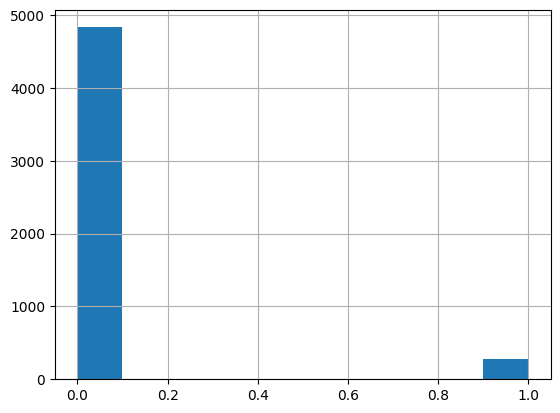

col:  ever_married


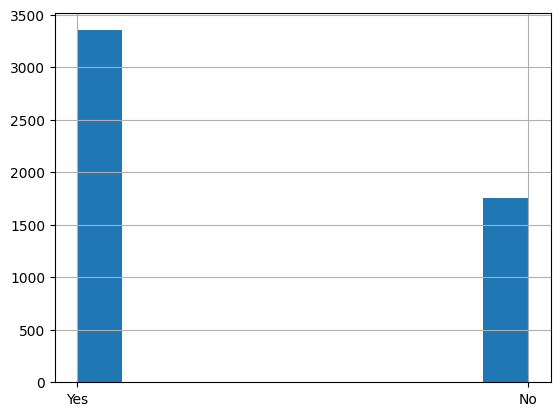

col:  work_type


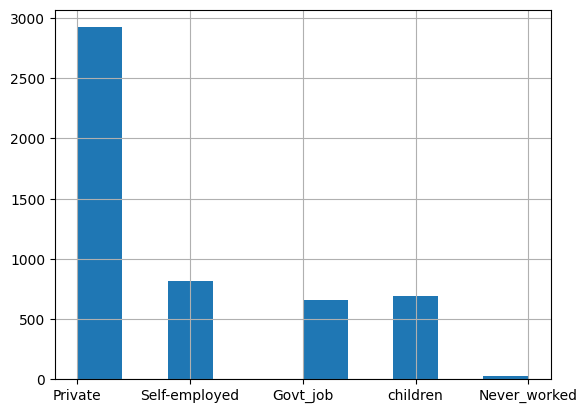

col:  Residence_type


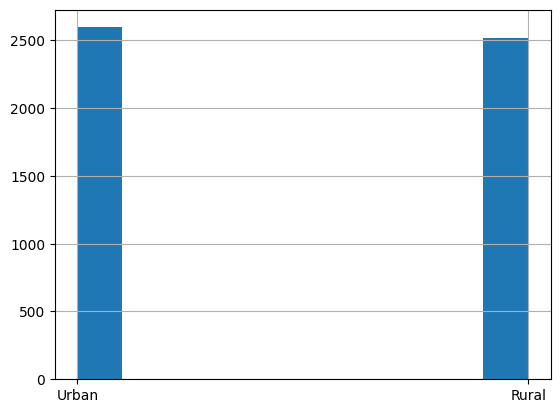

col:  avg_glucose_level


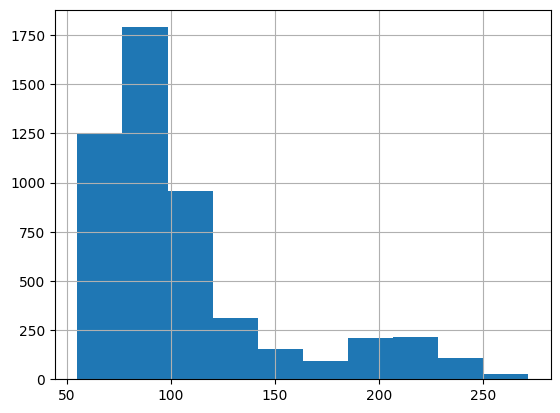

col:  bmi


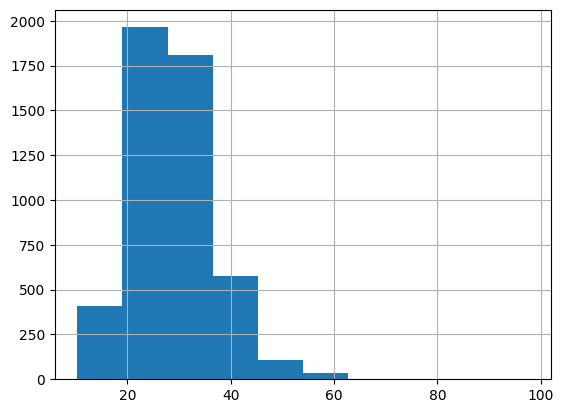

col:  smoking_status


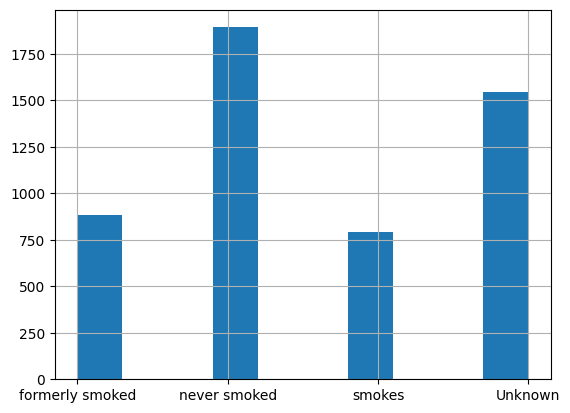

col:  stroke


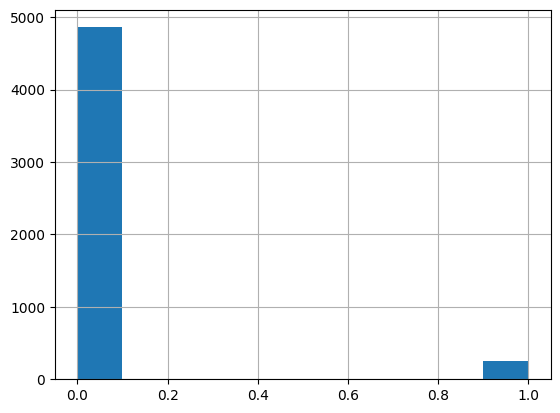

,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,67.0,0,1,228.69,36.6,1
1,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,61.0,0,0,202.21,0.0,1
2,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,80.0,0,1,105.92,32.5,1
3,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,49.0,0,0,171.23,34.4,1
4,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,79.0,1,0,174.12,24.0,1


In [23]:

# Show histogram for all columns
columns = data.columns
for col in columns:
    print("col: ", col)
    data[col].hist()
    plt.show()

# Show preprocessed dataframe
data_loader.preprocess_data()
data_loader.data.head()


In [15]:

# Install interpret
!pip install interpret --quiet


In [24]:

from interpret.glassbox import (LogisticRegression,
                                ClassificationTree,
                                ExplainableBoostingClassifier)
from interpret import show
from sklearn.metrics import f1_score, accuracy_score

# Load and preprocess data
data_loader = DataLoader()
data_loader.load_dataset()
data_loader.preprocess_data()


In [25]:


# Split the data for evaluation
X_train, X_test, y_train, y_test = data_loader.get_data_split()
print(X_train.shape)
print(X_test.shape)
# Oversample the train data
X_train, y_train = data_loader.oversample(X_train, y_train)
print("After oversampling:", X_train.shape)


(4088, 21)
(1022, 21)
After oversampling: (7778, 21)


In [26]:

# Fit logistic regression model
lr = LogisticRegression(random_state=2021, feature_names=X_train.columns, penalty='l1', solver='liblinear')
lr.fit(X_train, y_train)
print("Training finished.")


Training finished.


In [27]:

# Evaluate logistic regression model
y_pred = lr.predict(X_test)
print(f"F1 Score {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, y_pred)}")


F1 Score 0.5138996389726956
Accuracy 0.7348336594911937


In [28]:

# Explain local prediction
lr_local = lr.explain_local(X_test[:100], y_test[:100], name='Logistic Regression')
show(lr_local)

In [29]:


# Explain global logistic regression model
lr_global = lr.explain_global(name='Logistic Regression')
show(lr_global)

In [30]:


# Fit decision tree model
tree = ClassificationTree()
tree.fit(X_train, y_train)
print("Training finished.")
y_pred = tree.predict(X_test)
print(f"F1 Score {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, y_pred)}")

Training finished.
F1 Score 0.5259920468974536
Accuracy 0.761252446183953


In [31]:


# Explain local prediction
tree_local = tree.explain_local(X_test[:100], y_test[:100], name='Tree')
show(tree_local)
